In [1]:
import xarray as xr
import rioxarray
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def cdf(data):
    # compute cdf values for a 1D array of data
    data = data[~np.isnan(data)] # remove any NaN values
    x = np.sort(data) #sort data
    y = 1. * np.arange(len(data)) / (len(data) - 1) #calculate CDF values
    return x, y

In [4]:
def mountain_mask(ds, resampling=5):
    '''Given a dataset (ds), create a mountain mask from the MODIS Mountain Snow Classes map using reproject match.
       Use resampling=0 for nearest neighbor (when 1km mountain mask is coarser spatial resolution than target dataset)
       Use resampling=5 for average (when 1km mountain mask is finer spatial resolution than target dataset)
       More options and details here: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling'''
    
    # open the mountain mask file
    mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()
    
    # Clip to North America to match spatial extent of NoahMP models (Longitudes: -169 to -51, Latitudes: 24 to 72)
    min_lon, max_lon = -169, -51
    min_lat, max_lat = 24, 72
    mtnsnow_classes = mtnsnow_classes.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    
    # set values that are 256 (the nodata value) to zero before resampling
    mtnsnow_classes = mtnsnow_classes.where(mtnsnow_classes!=256, 0)
    
    # resample to match target dataset (ds) spatial resolution
    mtnsnow_classes_rpr = mtnsnow_classes.rio.reproject_match(ds, resampling=resampling)
    
    # create the mountain mask by finding all non-zero pixels, these are mountains
    mtn_mask = mtnsnow_classes_rpr.where(mtnsnow_classes_rpr>0).isnull()
    
    return mtn_mask

---

### North America, forest cover

In [5]:
base_filepath = 'C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/Snow Sensor Usability Paper - Passive Microwave/Data/'

### TCC

In [6]:
# read in TCC geotiff
na_tcc = xr.open_rasterio(base_filepath + 'forest_cover/global_forest_change_2019_v1_7.treecover2000.tif').squeeze()

# replace zero values with NaNs
na_tcc = na_tcc.where(na_tcc != 0)

# apply the mountain mask
na_tcc = na_tcc.where(mountain_mask(na_tcc).values)

# compute TCC CDF
na_tcc_cdf_x, na_tcc_cdf_y = cdf(na_tcc.values.ravel())

# convert to a pandas dataframe
na_tcc_cdf_df = pd.DataFrame(data={'cdf_x': na_tcc_cdf_x, 'cdf_y': na_tcc_cdf_y})

# export CDF values to a csv file
na_tcc_cdf_df.to_csv('na_tcc_CDF.csv')

### LAI

In [7]:
scale_factor = 0.1

# read in MODIS LAI February mean geotiff
na_lai = xr.open_rasterio(base_filepath + 'forest_cover/Lai.tif').squeeze()

# replace zero values with NaNs
na_lai = na_lai.where(na_lai != 0)

# apply the mountain mask
na_lai = na_lai.where(mountain_mask(na_lai).values)

# compute LAI CDF
na_lai_cdf_x, na_lai_cdf_y = cdf(na_lai.values.ravel()*scale_factor)

# convert to a pandas dataframe
na_lai_cdf_df = pd.DataFrame(data={'cdf_x': na_lai_cdf_x, 'cdf_y': na_lai_cdf_y})

# export CDF values to a csv file
na_lai_cdf_df.to_csv('na_lai_CDF.csv')

### Quebec, forest cover

Geotif outputs from the [Snow Sensor Usability Maps Google Earth Engine script](https://code.earthengine.google.com/?scriptPath=users%2Fspestana%2Fssum%3Amain) ran over Quebec, Canada for 2002 to 2018. The forest layers (TCC and LAI) for several output files are plotted below.

In [8]:
base_filepath = 'C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/Snow Sensor Usability Paper - Passive Microwave/sensitivity_test_results/ssum_output/'

### TCC
band 0 = MODIS LST; band 1 = Hansen et al., TCC; band 2 = NoahMP ECMWF SWE; band 3 = classes

In [9]:
ds = xr.open_rasterio(base_filepath + 'quebec_ssum_noahmp_ecmwf_150_tcc_20-30.tif')
qc_tcc = ds.isel(band=1)
# replace zero values with NaNs
qc_tcc = qc_tcc.where(qc_tcc != 0)
# compute TCC CDF
qc_tcc_cdf_x, qc_tcc_cdf_y = cdf(qc_tcc.values.ravel())
# convert to a pandas dataframe
qc_tcc_cdf_df = pd.DataFrame(data={'cdf_x': qc_tcc_cdf_x, 'cdf_y': qc_tcc_cdf_y})
# export CDF values to a csv file
qc_tcc_cdf_df.to_csv('qc_tcc_CDF.csv')

### LAI
band 0 = MODIS LST; band 1 = MODIS LAI; band 2 = GlobSnow SWE; band 3 = classes

In [10]:
scale_factor = 0.1
ds = xr.open_rasterio(base_filepath + 'quebec_ssum_globsnow_150_lai_18-38.tif')
qc_lai = ds.isel(band=1)
# replace zero values with NaNs
qc_lai = qc_lai.where(qc_tcc != 0)
# compute LAI CDF
qc_lai_cdf_x, qc_lai_cdf_y = cdf(qc_lai.values.ravel()*scale_factor)
# convert to a pandas dataframe
qc_lai_cdf_df = pd.DataFrame(data={'cdf_x': qc_lai_cdf_x, 'cdf_y': qc_lai_cdf_y})
# export CDF values to a csv file
qc_lai_cdf_df.to_csv('qc_lai_CDF.csv')

---

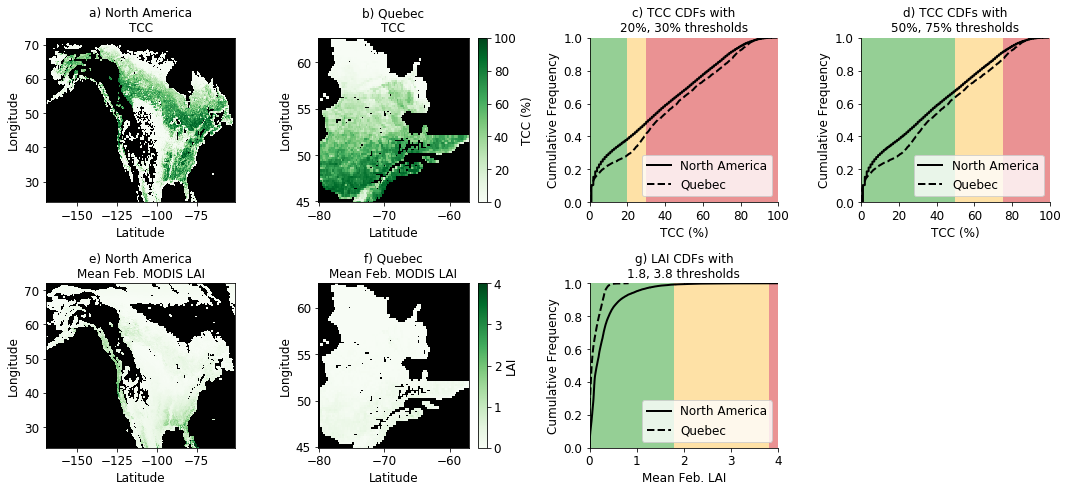

In [11]:
fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(15,7), tight_layout=True,gridspec_kw={'width_ratios': [1, 1, 1, 1]})
[ax_na_tcc, ax_qc_tcc, ax_tcc_cdf1, ax_tcc_cdf2, ax_na_lai, ax_qc_lai, ax_lai_cdf, ax_empty] = ax.ravel()

### Map plots ###
# North America, TCC map
na_tcc.plot(ax=ax_na_tcc, vmin=0, vmax=100, cmap='Greens', add_colorbar=False)# cbar_kwargs={'label': 'TCC (%)'})
# North America, LAI map
(na_lai*scale_factor).plot(ax=ax_na_lai, vmin=0, vmax=4, cmap='Greens', add_colorbar=False)# cbar_kwargs={'label': 'LAI'})
# Quebec, TCC map
qc_tcc.plot(ax=ax_qc_tcc, vmin=0, vmax=100, cmap='Greens', cbar_kwargs={'label': 'TCC (%)'})
# Quebec, LAI map
(qc_lai*scale_factor).plot(ax=ax_qc_lai, vmin=0, vmax=4, cmap='Greens', cbar_kwargs={'label': 'LAI'})
# format map plots
ax_na_tcc.set_title('a) North America\nTCC')
ax_na_lai.set_title('e) North America\nMean Feb. MODIS LAI')
ax_qc_tcc.set_title('b) Quebec\nTCC')
ax_qc_lai.set_title('f) Quebec\nMean Feb. MODIS LAI')
for this_ax in [ax_na_tcc, ax_na_lai]:
    this_ax.set_ylim(24,72)
    this_ax.set_ylabel('Longitude')
    this_ax.set_xlabel('Latitude')
    this_ax.set_facecolor("black")
for this_ax in [ax_qc_tcc, ax_qc_lai]:
    this_ax.set_ylabel('Longitude')
    this_ax.set_xlabel('Latitude')
    this_ax.set_facecolor("black")
    
    
### CDF Plots ###
# TCC CDF #1
ax_tcc_cdf1.plot(na_tcc_cdf_x, na_tcc_cdf_y, '-', lw=2, c='k', label='North America', zorder=999)
ax_tcc_cdf1.plot(qc_tcc_cdf_x, qc_tcc_cdf_y, '--', lw=2, c='k', label='Quebec', zorder=999)
# add vertical bands for TCC thresholds
ax_tcc_cdf1.fill_between([20, 30], y1=1, y2=0, facecolor='#fec44f', alpha=0.5)
ax_tcc_cdf1.fill_between([0, 20], y1=1, y2=0, facecolor='tab:green', alpha=0.5)
ax_tcc_cdf1.fill_between([30, 100], y1=1, y2=0, facecolor='tab:red', alpha=0.5)

# TCC CDF #2
ax_tcc_cdf2.plot(na_tcc_cdf_x, na_tcc_cdf_y, '-', lw=2, c='k', label='North America', zorder=999)
ax_tcc_cdf2.plot(qc_tcc_cdf_x, qc_tcc_cdf_y, '--', lw=2, c='k', label='Quebec', zorder=999)
# add vertical bands for TCC thresholds
ax_tcc_cdf2.fill_between([50, 75], y1=1, y2=0, facecolor='#fec44f', alpha=0.5)
ax_tcc_cdf2.fill_between([0, 50], y1=1, y2=0, facecolor='tab:green', alpha=0.5)
ax_tcc_cdf2.fill_between([75, 100], y1=1, y2=0, facecolor='tab:red', alpha=0.5)

# LAI CDF
ax_lai_cdf.plot(na_lai_cdf_x, na_lai_cdf_y, '-', lw=2, c='k', label='North America', zorder=999)
ax_lai_cdf.plot(qc_lai_cdf_x, qc_lai_cdf_y, '--', lw=2, c='k', label='Quebec', zorder=999)
# add vertical bands for LAI thresholds
ax_lai_cdf.fill_between([1.8,3.8], y1=1, y2=0, facecolor='#fec44f', alpha=0.5)
ax_lai_cdf.fill_between([0, 1.8], y1=1, y2=0, facecolor='tab:green', alpha=0.5)
ax_lai_cdf.fill_between([3.8, 10], y1=1, y2=0, facecolor='tab:red', alpha=0.5)


# format CDF plots
#ax.set_xlim((-5,100))
#fig.suptitle('CDFs of TCC and LAI')
for this_ax in [ax_tcc_cdf1, ax_tcc_cdf2]:
    this_ax.set_ylabel('Cumulative Frequency')
    this_ax.set_xlabel('TCC (%)')
    this_ax.set_ylim(0,1)
    this_ax.set_xlim(0,100)
    this_ax.spines['top'].set_visible(False)
    this_ax.spines['right'].set_visible(False)
    this_ax.legend(loc='lower right', frameon=True);
ax_lai_cdf.set_ylabel('Cumulative Frequency')
ax_lai_cdf.set_xlabel('Mean Feb. LAI')
ax_lai_cdf.set_ylim(0,1)
ax_lai_cdf.set_xlim(0,4)
ax_lai_cdf.spines['top'].set_visible(False)
ax_lai_cdf.spines['right'].set_visible(False)
ax_lai_cdf.legend(loc='lower right', frameon=True);
ax_tcc_cdf1.set_title('c) TCC CDFs with\n20%, 30% thresholds')
ax_tcc_cdf2.set_title('d) TCC CDFs with\n50%, 75% thresholds')
ax_lai_cdf.set_title('g) LAI CDFs with\n1.8, 3.8 thresholds')

ax_empty.axis('off')

# save figure
plt.savefig('figures/forest-mountainsmasked.jpg')